In [382]:
import bootcampviztools as bt
from datetime import datetime
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
import warnings

from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score,\
                            roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [159]:
archivo_csv = "data/fraud.csv"
df = pd.read_csv(archivo_csv)

In [258]:
df.shape

(555719, 23)

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

**Unnamed: 0:**   Un índice sin nombre, posiblemente un índice adicional generado durante la lectura o manipulación de los datos.  
**trans_date_trans_time:**   La fecha y hora de la transacción.  
**cc_num:**   El número de la tarjeta de crédito utilizado en la transacción.  
**merchant:**   El nombre del comerciante o establecimiento donde se realizó la transacción.  
**category:**   La categoría de la transacción.  
**amt:**   El monto de la transacción.  
**first:**   El primer nombre del titular de la tarjeta.  
**last:**   El apellido del titular de la tarjeta.  
**gender:**   El género del titular de la tarjeta.  
**street:**   La dirección de la calle del titular de la tarjeta.  
**city:**   La ciudad del titular de la tarjeta.     
**state:**   El estado del titular de la tarjeta.  
**zip:**   El código postal del titular de la tarjeta.    
**lat:**   La latitud de la ubicación del titular de la tarjeta.  
**long:**   La longitud de la ubicación del titular de la tarjeta.  
**city_pop:**   La población de la ciudad del titular de la tarjeta.  
**job:**   El trabajo u ocupación del titular de la tarjeta.  
**dob:**   La fecha de nacimiento del titular de la tarjeta.  
**trans_num:**   Un número único de transacción.  
**unix_time:**   La marca de tiempo de la transacción en formato Unix.  
**merch_lat:**   La latitud de la ubicación del comerciante.  
**merch_long:**   La longitud de la ubicación del comerciante.  

In [162]:
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,555719.000000,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,5.557190e+05,555719.000000,555719.000000,555719.000000
mean,277859.000000,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1.380679e+09,38.542798,-90.231380,0.003860
std,160422.401459,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,5.201104e+06,5.095829,13.733071,0.062008
min,0.000000,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.371817e+09,19.027422,-166.671575,0.000000
25%,138929.500000,1.800430e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1.376029e+09,34.755302,-96.905129,0.000000
50%,277859.000000,3.521420e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1.380762e+09,39.376593,-87.445204,0.000000
75%,416788.500000,4.635330e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1.385867e+09,41.954163,-80.264637,0.000000
max,555718.000000,4.992350e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,1.388534e+09,66.679297,-66.952026,1.000000


In [163]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [164]:
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [165]:
def data_report(df):
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T
        
data_report(df)

COL_N,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
DATA_TYPE,int64,object,float64,object,object,float64,object,object,object,object,...,float64,float64,int64,object,object,object,int64,float64,float64,int64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,555719,226976,904,693,14,37256,341,471,2,924,...,910,910,835,478,910,555719,544760,546490,551770,2
CARDIN (%),100.0,40.84,0.16,0.12,0.0,6.7,0.06,0.08,0.0,0.17,...,0.16,0.16,0.15,0.09,0.16,100.0,98.03,98.34,99.29,0.0


In [166]:
def data_report(df):
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado
        
data_report(df)

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
COL_N,,,,
Unnamed: 0,int64,0.0,555719,100.00
trans_date_trans_time,object,0.0,226976,40.84
cc_num,float64,0.0,904,0.16
merchant,object,0.0,693,0.12
category,object,0.0,14,0.00
amt,float64,0.0,37256,6.70
first,object,0.0,341,0.06
last,object,0.0,471,0.08
gender,object,0.0,2,0.00


In [167]:
corr = df.corr(numeric_only=True)

In [168]:
corr['is_fraud'].sort_values(ascending=False)

is_fraud      1.000000
amt           0.182267
lat           0.005863
merch_lat     0.005812
long         -0.000972
merch_long   -0.001060
cc_num       -0.001540
zip          -0.002271
city_pop     -0.004910
unix_time    -0.013066
Unnamed: 0   -0.013892
Name: is_fraud, dtype: float64

In [169]:
np.abs(corr['is_fraud']).sort_values(ascending=False)

is_fraud      1.000000
amt           0.182267
Unnamed: 0    0.013892
unix_time     0.013066
lat           0.005863
merch_lat     0.005812
city_pop      0.004910
zip           0.002271
cc_num        0.001540
merch_long    0.001060
long          0.000972
Name: is_fraud, dtype: float64

<Axes: >

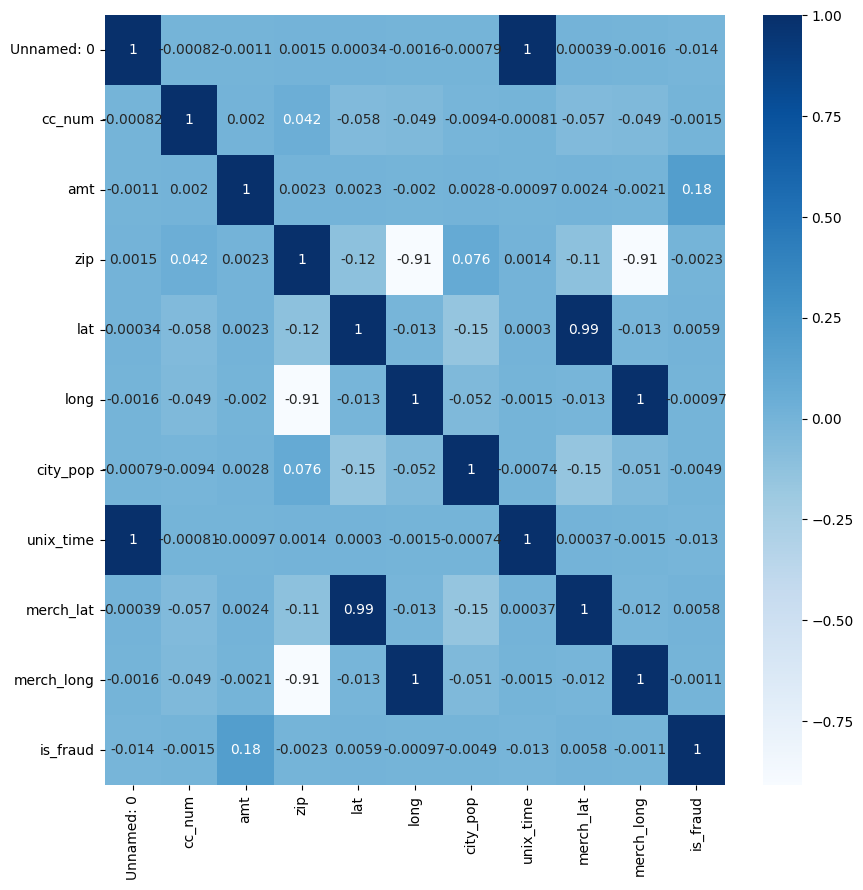

In [170]:
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='Blues')

In [171]:
df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                   float64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

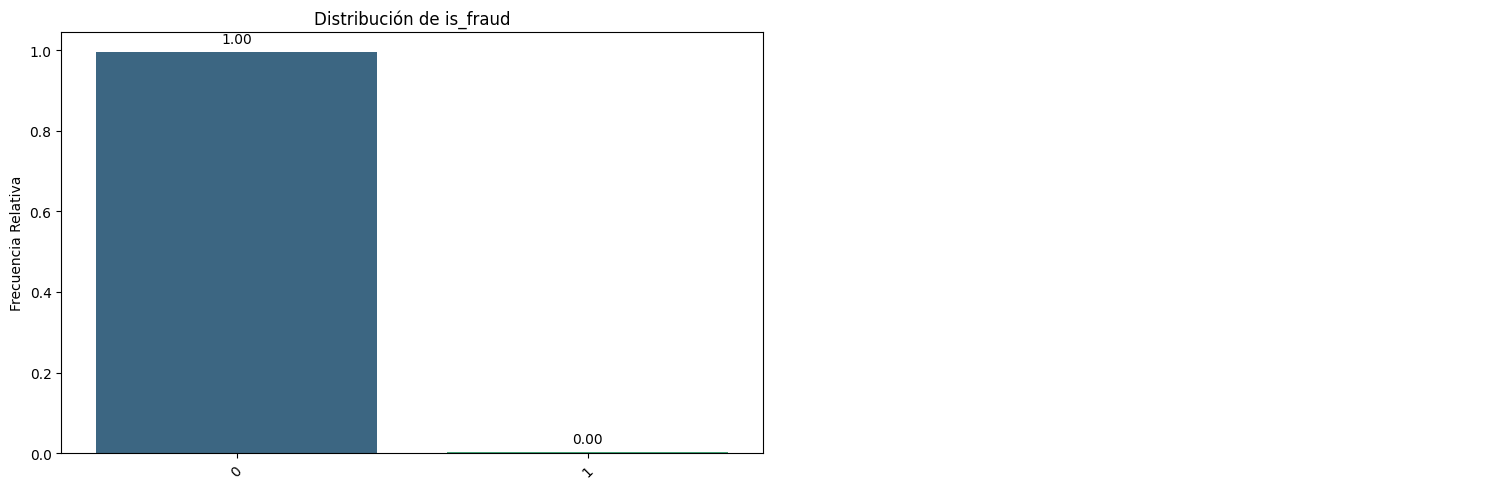

In [172]:
bt.pinta_distribucion_categoricas(df,["is_fraud"], relativa= True, mostrar_valores= True)

In [173]:
df['is_fraud'].value_counts(normalize=True)

is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64

Nos enfrentamos a un desbalance muy acusado de clases, para manejarlo vamos a utilizar algoritmos sensibles al desbalance: 

Algoritmos basados en árboles de decisión o los basados en instancias, pueden manejar naturalmente el desbalance de clases sin necesidad de técnicas adicionales.

In [174]:
# Lista de columnas numéricas y categóricas
# List of numeric and categorical columns
columna_numerica = ['cc_num', 'amt', 'zip', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long']


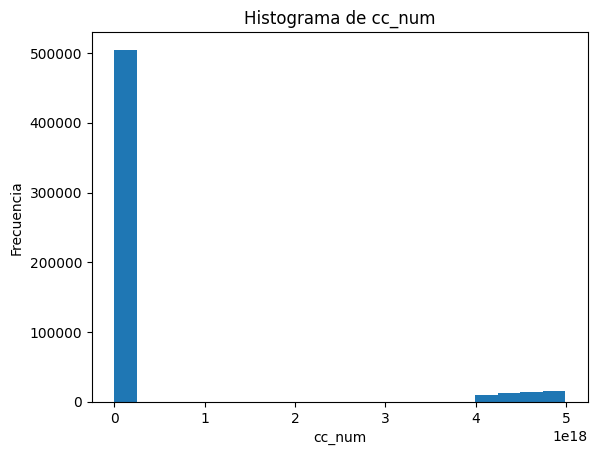

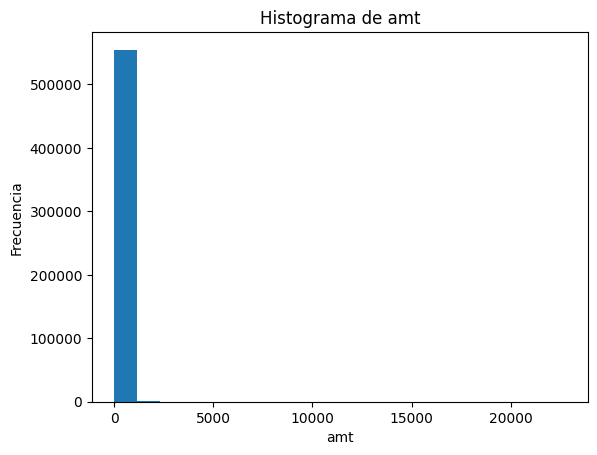

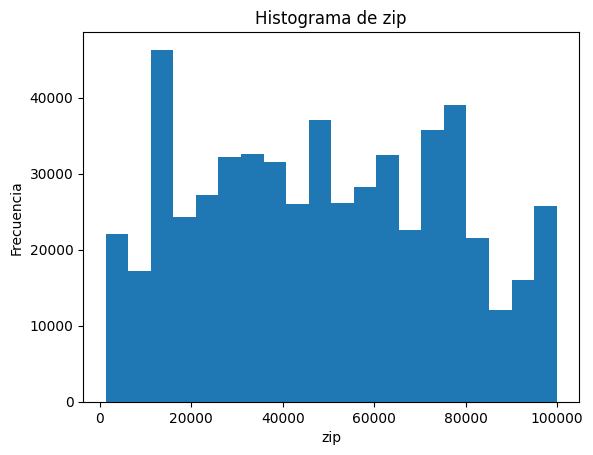

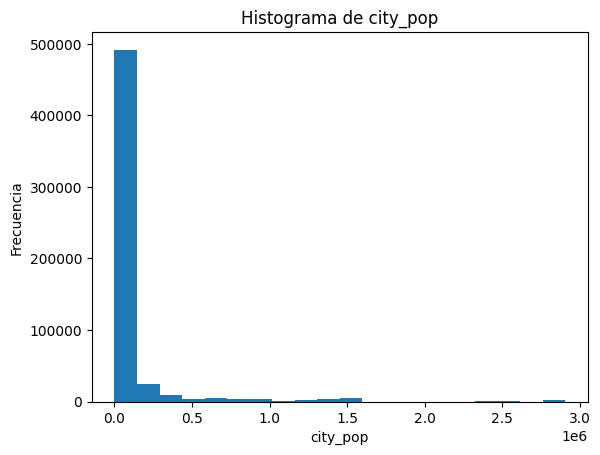

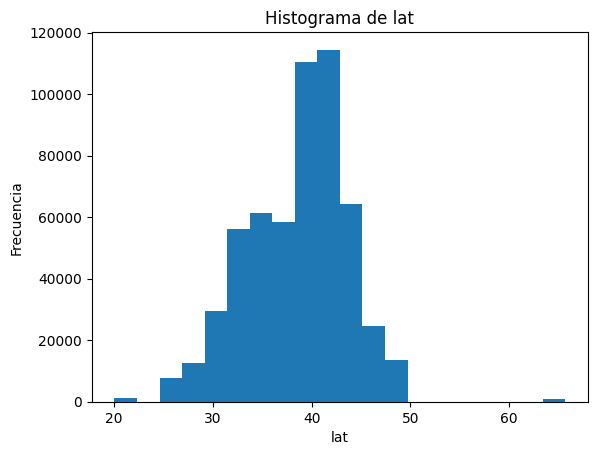

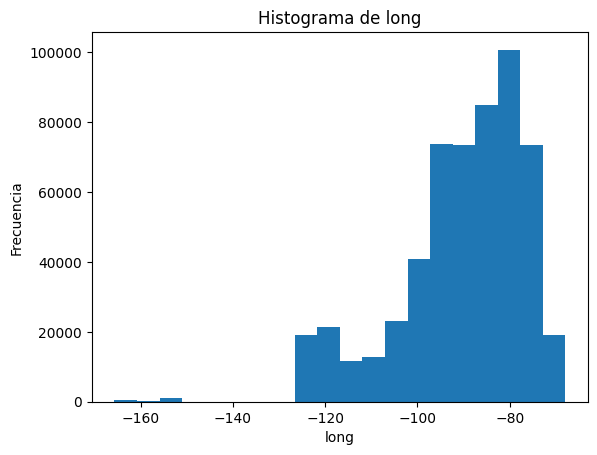

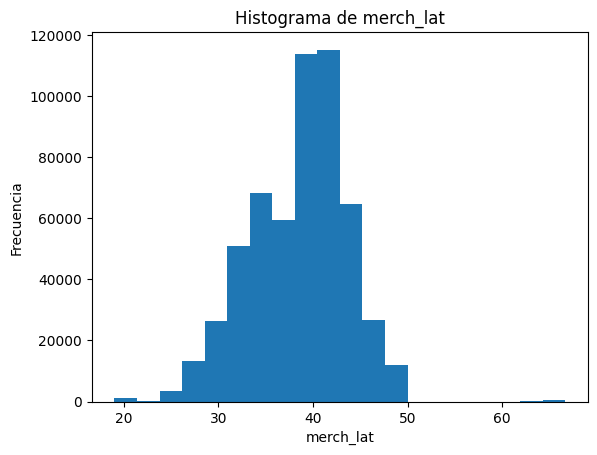

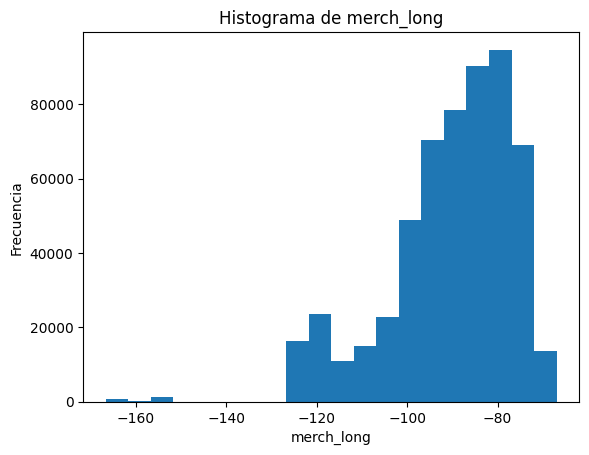

In [175]:
# Crear un histograma para cada columna numérica
# Create a histogram for each numeric column
for col in columna_numerica:
    plt.hist(df[col], bins=20)
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.title('Histograma de ' + col)
    plt.show()

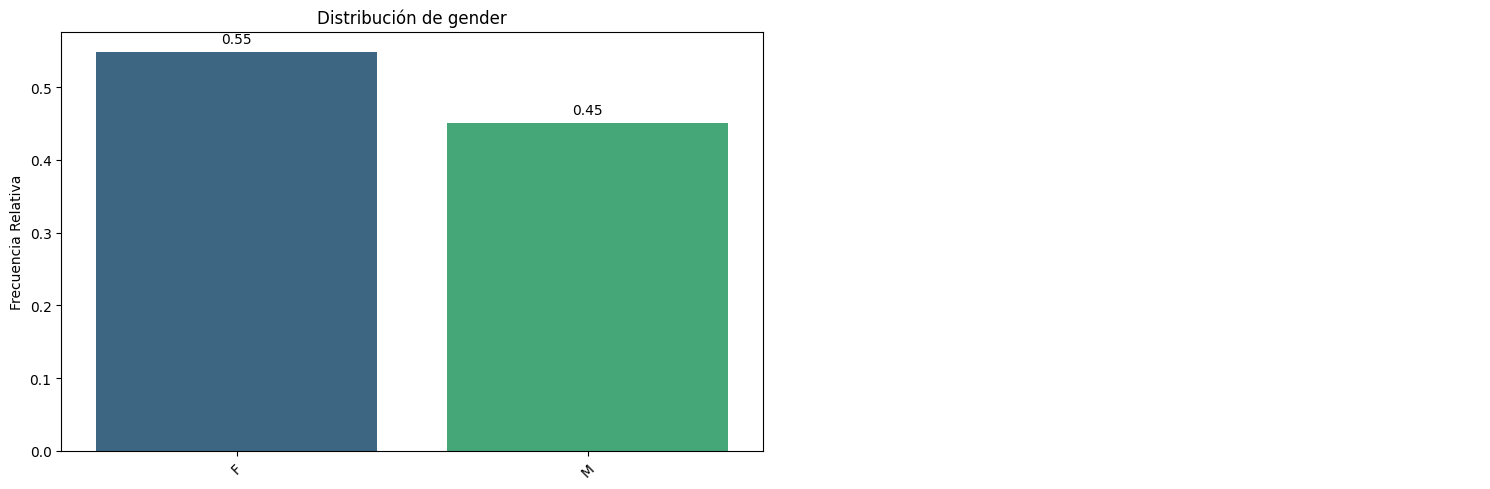

In [178]:
bt.pinta_distribucion_categoricas(df,["gender"], relativa= True, mostrar_valores= True)

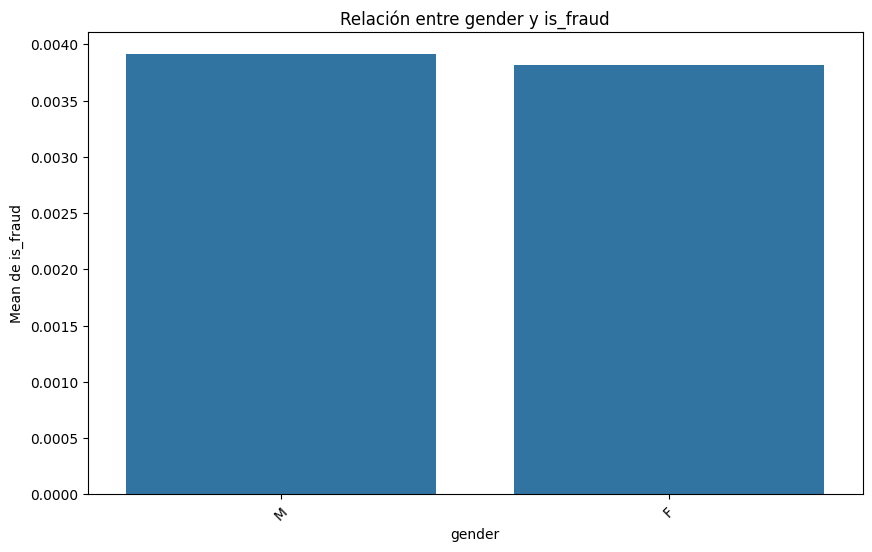

In [179]:
bt.plot_categorical_numerical_relationship(df,"gender","is_fraud", measure = "mean")

In [180]:
df['is_fraud'] = df['is_fraud'].astype(int)

# Agrupar los datos por estado y luego sumar los valores de la columna de fraude para cada estado
# Group the data by state and then sum the fraud column values for each state
fraudes_por_estado = df.groupby('state')['is_fraud'].sum()
fraudes_por_estado

state
AK     14
AL     63
AR     34
AZ     27
CA     76
CO      2
CT     40
DC     10
FL     53
GA     58
HI      9
IA     69
ID     22
IL     76
IN     75
KS     37
KY     67
LA     22
MA     18
MD     46
ME     15
MI     61
MN     73
MO     71
MS     54
MT     37
NC     46
ND     27
NE     36
NH     20
NJ     43
NM     39
NV      0
NY    175
OH     39
OK     57
OR     48
PA    114
RI      0
SC     43
SD     18
TN     19
TX    113
UT      0
VA     75
VT      0
WA     30
WI     65
WV      0
WY      9
Name: is_fraud, dtype: int32

In [337]:
# Agrupamos y sumamos
# Group and add
result = df.groupby(['state', 'is_fraud']).agg({'amt': 'sum'}).unstack()

# Calculamos el porcentaje
# Calculate the percentage
result['porcentaje_fraude'] = result['amt'][1] / (result['amt'][0] + result['amt'][1])

# Redondeamos el porcentaje a 4 decimales
# Round the percentage to 4 decimal places
result['porcentaje_fraude'] = result['porcentaje_fraude'].round(4)

# Ordenamos por porcentaje de fraude de forma ascendente
# Sort by fraud percentage in ascending order
result = result.sort_values(by='porcentaje_fraude', ascending=False)

In [338]:
result

amt           porcentaje_fraude
is_fraud           0         1                  
state                                           
AK          54430.72  11641.22            0.1762
HI          58693.53   6164.72            0.0950
CT         187199.65  17977.25            0.0876
DC         102140.68   6640.64            0.0610
NM         408338.53  23867.97            0.0552
ID         187157.10  10548.17            0.0534
MS         568523.26  31010.02            0.0517
KY         814378.75  42175.29            0.0492
VA         826403.39  41752.78            0.0481
WI         833723.09  40039.48            0.0458
IA         735782.46  34808.15            0.0452
MT         374047.06  17561.53            0.0448
GA         746682.93  33619.50            0.0431
OR         507245.46  22799.97            0.0430
IN         811797.21  34953.10            0.0413
AZ         333781.76  14119.83            0.0406
NH         265919.38  11118.66            0.0401
NY        2429994.97  99746.68            0.0394
MN         922046.87  36080.51            0.0377
MD         656279.98  25470.69            0.0374
OK         721412.42  26992.48            0.0361
NJ         687863.49  25654.85            0.0360
KS         686433.06  24870.42            0.0350
MO        1062070.80  38223.18            0.0347
ND         404794.69  14409.83            0.0344
AL        1091448.30  36474.51            0.0323
NE         625498.48  19340.76            0.0300
SD         352448.72  10003.97            0.0276
IL        1274318.44  35657.45            0.0272
MI        1362223.48  37753.48            0.0270
WA         570639.12  15593.19            0.0266
PA        2371811.70  62807.61            0.0258
ME         424778.42   9152.98            0.0211
MA         317852.19   6600.80            0.0203
NC         980143.69  20113.62            0.0201
CA        1733796.20  34995.06            0.0198
SC         754023.48  15078.28            0.0196
TX        2704186.84  52310.40            0.0190
FL        1270448.98  22734.52            0.0176
OH        1404309.51  23080.46            0.0162
AR        1011345.22  16605.22            0.0162
LA         650183.13  10249.12            0.0155
TN         506139.13   7921.02            0.0154
WY         631089.49   4455.27            0.0070
CO         446923.42    150.04            0.0003
NV         131077.59       NaN               NaN
RI           7330.92       NaN               NaN
UT         286190.19       NaN               NaN
VT         388414.99       NaN               NaN
WV         745815.56       NaN               NaN

In [339]:
# Reiniciar el índice para eliminar 'state' como índice y convertirlo en una columna
# Reset the index to remove 'state' as an index and make it a column
df_reset = result.reset_index()

# Ajustar el nombre de las columnas
# Adjust column names
df_reset.columns = ['state', 'amt0', 'amt1', 'porcentaje_fraude']

In [340]:
df_reset

,state,amt0,amt1,porcentaje_fraude
0,AK,54430.72,11641.22,0.1762
1,HI,58693.53,6164.72,0.0950
2,CT,187199.65,17977.25,0.0876
3,DC,102140.68,6640.64,0.0610
4,NM,408338.53,23867.97,0.0552
5,ID,187157.10,10548.17,0.0534
6,MS,568523.26,31010.02,0.0517
7,KY,814378.75,42175.29,0.0492
8,VA,826403.39,41752.78,0.0481
9,WI,833723.09,40039.48,0.0458


In [341]:
# Agrupar por 'state' y 'city', luego calcular la máxima población de la ciudad
# Group by 'state' and 'city', then calculate maximum city population
grouped_df = df.groupby(['state', 'city'])['city_pop'].max().reset_index()

# Agrupar por 'state' y calcular la suma de las poblaciones de las ciudades
# Group by 'state' and calculate sum of city populations
pop = grouped_df.groupby('state')['city_pop'].sum().reset_index()


In [342]:
pop

,state,city_pop
0,AK,2342
1,AL,1476502
2,AR,90631
3,AZ,1334779
4,CA,7254731
5,CO,1688261
6,CT,13551
7,DC,601723
8,FL,3593018
9,GA,324367


In [343]:
# Realizar la fusión entre df_reset y pop utilizando la columna 'state'
# Perform the merge between df_reset and pop using the 'state' column
merged_df = pd.merge(df_reset, pop, on='state')

In [344]:
merged_df

,state,amt0,amt1,porcentaje_fraude,city_pop
0,AK,54430.72,11641.22,0.1762,2342
1,HI,58693.53,6164.72,0.0950,6368
2,CT,187199.65,17977.25,0.0876,13551
3,DC,102140.68,6640.64,0.0610,601723
4,NM,408338.53,23867.97,0.0552,693381
5,ID,187157.10,10548.17,0.0534,92550
6,MS,568523.26,31010.02,0.0517,317320
7,KY,814378.75,42175.29,0.0492,1140445
8,VA,826403.39,41752.78,0.0481,1008115
9,WI,833723.09,40039.48,0.0458,996304


In [345]:
# Calculamos el índice de fraude per cápita
# Calculate the fraud rate per capita
merged_df['fraude_per_capita'] =  merged_df['porcentaje_fraude'] /merged_df['city_pop'] 

# Ordenamos por el índice de fraude per cápita en orden descendente
# Sort by the fraud rate per capita in descending order
fraud_state = merged_df.sort_values(by='fraude_per_capita', ascending=False)

In [346]:
fraud_state

,state,amt0,amt1,porcentaje_fraude,city_pop,fraude_per_capita
0,AK,54430.72,11641.22,0.1762,2342,7.523484e-05
1,HI,58693.53,6164.72,0.0950,6368,1.491834e-05
24,ND,404794.69,14409.83,0.0344,4004,8.591409e-06
2,CT,187199.65,17977.25,0.0876,13551,6.464468e-06
27,SD,352448.72,10003.97,0.0276,13031,2.118026e-06
11,MT,374047.06,17561.53,0.0448,23006,1.947318e-06
16,NH,265919.38,11118.66,0.0401,28079,1.428114e-06
5,ID,187157.10,10548.17,0.0534,92550,5.769854e-07
32,ME,424778.42,9152.98,0.0211,61789,3.414847e-07
40,AR,1011345.22,16605.22,0.0162,90631,1.787468e-07


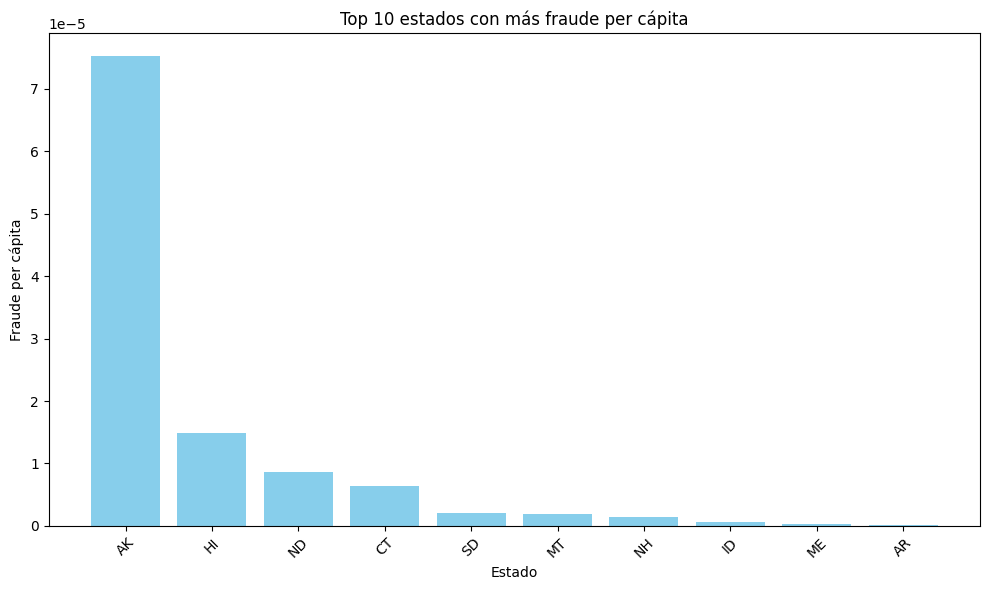

In [351]:
# Ordenar el DataFrame por 'porcentaje_fraude' de forma descendente
# Sort the DataFrame by 'fraud_percentage' in descending order
merged_df_sorted = fraud_state.sort_values(by='fraude_per_capita', ascending=False)

# Seleccionar los 10 estados con mayor fraude per cápita
# Select the 10 states with the highest fraud per capita
top_10_states = merged_df_sorted.head(10)

# Crear el gráfico de barras
# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_states['state'], top_10_states['fraude_per_capita'], color='skyblue')
plt.xlabel('Estado')
plt.ylabel('Fraude per cápita')
plt.title('Top 10 estados con más fraude per cápita')
plt.xticks(rotation=45)  
plt.tight_layout()

plt.show()

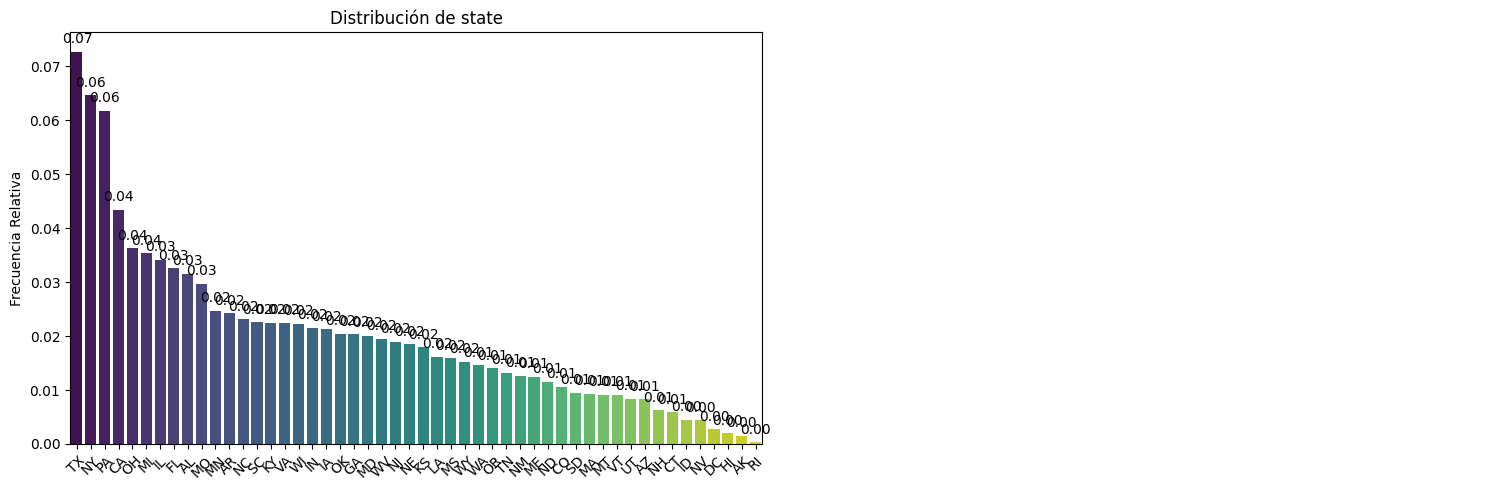

In [ ]:
bt.pinta_distribucion_categoricas(df,["state"], relativa= True, mostrar_valores= True)

In [349]:
# Agrupamos y sumamos
# Group and add
cat = df.groupby(['category', 'is_fraud']).agg({'amt': 'sum'}).unstack()

# Calculamos el porcentaje
# Calculate the percentage
cat['porcentaje_fraude'] = cat['amt'][1] / (cat['amt'][0] + cat['amt'][1])

# Redondeamos el porcentaje a 4 decimales
# Round the percentage to 4 decimal places
cat['porcentaje_fraude'] = cat['porcentaje_fraude'].round(4)

# Ordenamos por porcentaje de fraude de forma ascendente
# Sort by fraud percentage in ascending order
cat = cat.sort_values(by='porcentaje_fraude', ascending=False)

In [350]:
cat

amt            porcentaje_fraude
is_fraud                 0          1                  
category                                               
shopping_net    2984656.06  503123.93            0.1443
misc_net        1936309.73  214742.95            0.0998
shopping_pos    3638171.36  188887.25            0.0494
grocery_pos     5938254.87  151866.72            0.0249
entertainment   2535971.85   30076.17            0.0117
misc_pos        2135965.15   13923.82            0.0065
home            3018509.59   17260.30            0.0057
food_dining     1987340.54    6607.54            0.0033
personal_care   1895045.56    1814.44            0.0010
gas_transport   3581987.14    1848.42            0.0005
grocery_net     1043312.98     478.39            0.0005
health_fitness  1974475.87    1058.32            0.0005
kids_pets       2798838.14    1288.45            0.0005
travel          1960739.59     347.98            0.0002

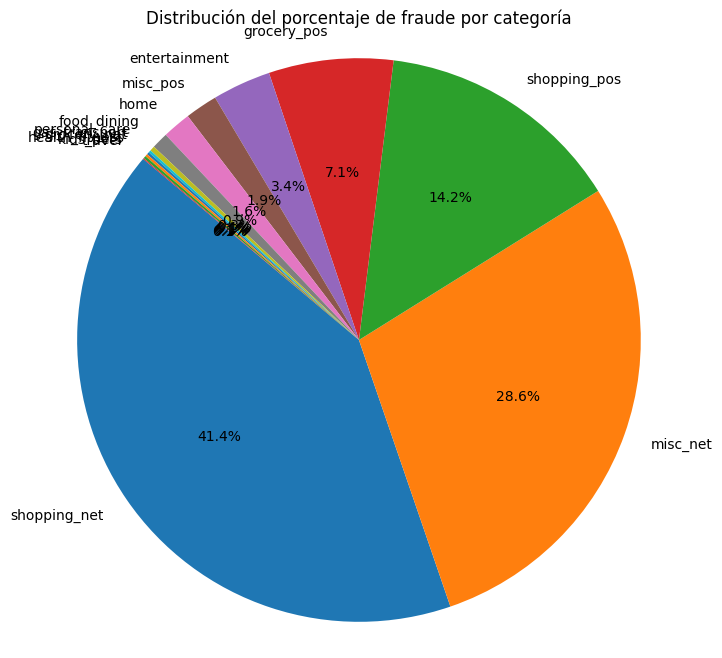

In [353]:
# Obtener los valores de porcentaje de fraude y las etiquetas de categorías
# Get fraud percentage values and category labels
porcentajes = cat['porcentaje_fraude']
categorias = cat.index

# Crear el gráfico circular
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(porcentajes, labels=categorias, autopct='%1.1f%%', startangle=140)
plt.title('Distribución del porcentaje de fraude por categoría')
plt.axis('equal')  # Para asegurar que el gráfico sea un círculo
plt.show()



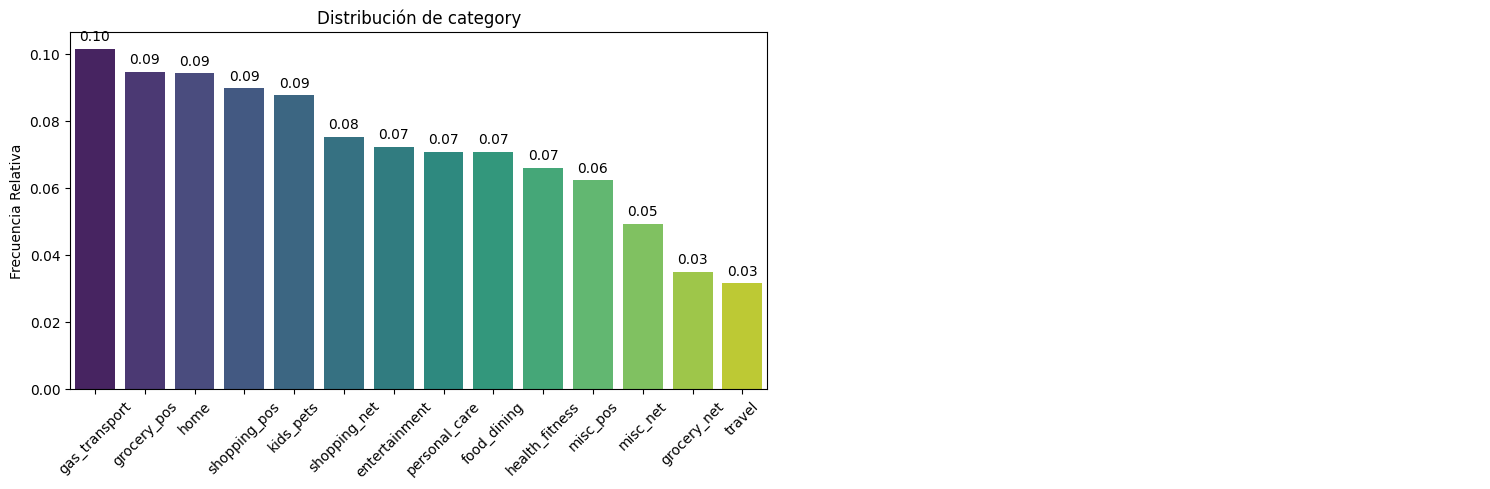

In [ ]:
bt.pinta_distribucion_categoricas(df,["category"], relativa= True, mostrar_valores= True)

In [366]:
# Convertir la columna 'dob' a formato de fecha
# Convert 'dob' column to date format
df['dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y')

# Obtener el año actual
# Get current year
ano_actual = datetime.now().year

# Calcular la edad restando el año de nacimiento del año actual
# Calculate age by subtracting year of birth from current year
df['edad'] = ano_actual - df['dob'].dt.year



In [367]:
# Agrupamos y sumamos
# Group and add
age = df.groupby(['edad', 'is_fraud']).agg({'amt': 'sum'}).unstack()

# Calculamos el porcentaje
# Calculate the percentage
age['porcentaje_fraude'] = age['amt'][1] / (age['amt'][0] + age['amt'][1])

# Redondeamos el porcentaje a 4 decimales
# Round the percentage to 4 decimal places
age['porcentaje_fraude'] = age['porcentaje_fraude'].round(4)

# Ordenamos por porcentaje de fraude de forma ascendente
# Sort by fraud percentage in ascending order
age = age.sort_values(by='porcentaje_fraude', ascending=False)

# Eliminar filas con valores NaN en el DataFrame 'age'
# Delete rows with NaN values in the 'age' DataFrame
age.dropna(inplace=True)

In [370]:
age

,age,amt0,amt1,porcentaje_fraude
0,100,13477.88,3438.64,0.2033
1,81,92377.30,13269.61,0.1256
2,56,460344.08,48595.08,0.0955
3,88,169955.71,14882.67,0.0805
4,92,54833.02,4253.58,0.0720
...,...,...,...,...
61,53,899500.81,10880.15,0.0120
62,43,685539.19,6419.59,0.0093
63,50,1108475.50,10347.91,0.0092
64,44,820507.75,7141.61,0.0086


In [369]:
# Reiniciar el índice para eliminar 'state' como índice y convertirlo en una columna
# Reset the index to remove 'state' as an index and make it a column
age = age.reset_index()

# Ajustar el nombre de las columnas
# Adjust column names
age.columns = ['age', 'amt0', 'amt1', 'porcentaje_fraude']

In [371]:
age

,age,amt0,amt1,porcentaje_fraude
0,100,13477.88,3438.64,0.2033
1,81,92377.30,13269.61,0.1256
2,56,460344.08,48595.08,0.0955
3,88,169955.71,14882.67,0.0805
4,92,54833.02,4253.58,0.0720
...,...,...,...,...
61,53,899500.81,10880.15,0.0120
62,43,685539.19,6419.59,0.0093
63,50,1108475.50,10347.91,0.0092
64,44,820507.75,7141.61,0.0086


In [372]:
# Definir los límites de los intervalos
# Define the limits of the intervals
bins = [0, 21, 35, 55, float('inf')]

# Etiquetas para los intervalos
# Labels for intervals
labels = ['0-20', '21-35', '36-55', '55+']

# Crear una nueva columna en el DataFrame 'age' que represente el rango de edades
# Create a new column in the 'age' DataFrame that represents the age range
age['grupo_edades'] = pd.cut(age['age'], bins=bins, labels=labels, right=False)


In [373]:
age

,age,amt0,amt1,porcentaje_fraude,grupo_edades
0,100,13477.88,3438.64,0.2033,55+
1,81,92377.30,13269.61,0.1256,55+
2,56,460344.08,48595.08,0.0955,55+
3,88,169955.71,14882.67,0.0805,55+
4,92,54833.02,4253.58,0.0720,55+
...,...,...,...,...,...
61,53,899500.81,10880.15,0.0120,36-55
62,43,685539.19,6419.59,0.0093,36-55
63,50,1108475.50,10347.91,0.0092,36-55
64,44,820507.75,7141.61,0.0086,36-55


C:\Users\julio\AppData\Local\Temp\ipykernel_4040\1969853946.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupo_edades_suma_amt1 = age.groupby('grupo_edades')['amt1'].sum()


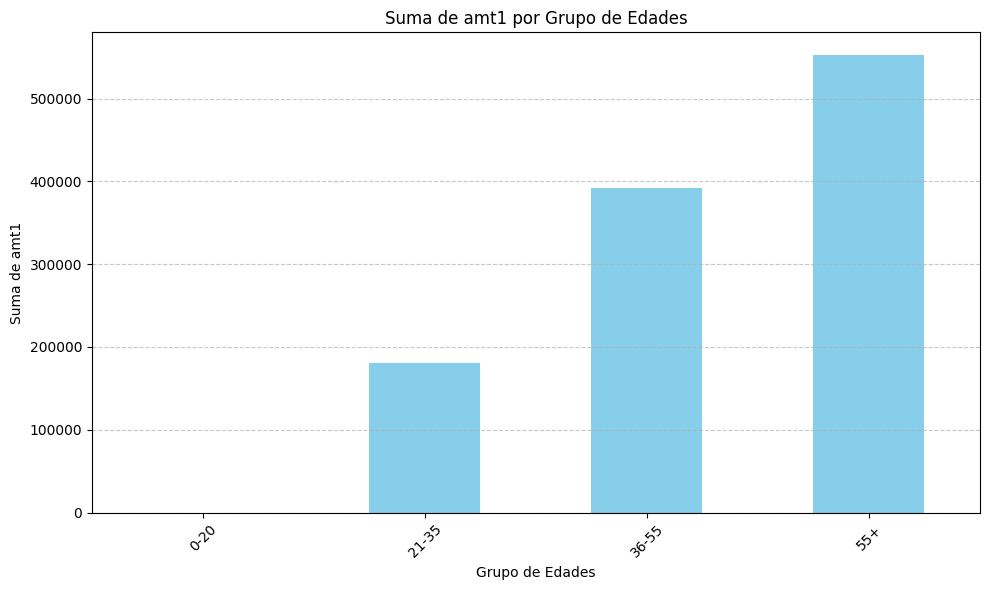

In [374]:
# Agrupar el DataFrame 'age' por 'grupo_edades' y calcular la suma de 'amt1'
# Group the DataFrame 'age' by 'age_group' and calculate the sum of 'amt1'
grupo_edades_suma_amt1 = age.groupby('grupo_edades')['amt1'].sum()

# Crear el gráfico de barras
# Create the bar chart
plt.figure(figsize=(10, 6))
grupo_edades_suma_amt1.plot(kind='bar', color='skyblue')
plt.xlabel('Grupo de Edades')
plt.ylabel('Suma de amt1')
plt.title('Suma de amt1 por Grupo de Edades')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
# Show the graph
plt.show()


## Dividimos en train y test

In [385]:
# Definir target
# Define target
y = df['is_fraud']

# Definir las características (features)
# Define the features
X = df.drop('is_fraud', axis=1)

# Modificar el split de los datos
# Modify the data split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [182]:
X_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long
139526,139526,09/08/2020 11:30,3.741250e+14,"fraud_Christiansen, Goyette and Schamberger",gas_transport,61.74,Christopher,Gilbert,M,20937 Reed Lakes Apt. 271,...,20012,38.9757,-77.0282,601723,"Optician, dispensing",20/07/1970,c738b10b4f58c3e95cb0eeea7556a8ed,1376047844,38.368797,-76.170115
395747,395747,23/11/2020 15:11,3.527540e+15,fraud_Turcotte-Halvorson,misc_pos,186.93,Teresa,Stein,F,2838 White Fields Apt. 473,...,29911,32.9413,-81.1807,1725,Social researcher,05/12/1974,c7082601037e96bc0513c6e910c3f889,1385219474,32.342834,-81.123567
395119,395119,23/11/2020 11:06,3.558880e+15,fraud_Pacocha-O'Reilly,grocery_pos,127.61,Christopher,Holt,M,05597 Michael Spurs,...,86018,35.2563,-111.9500,759,"Geologist, engineering",28/03/1957,c1d2d3499a9e0ca17e6c31010a42936a,1385204770,36.255327,-112.176851
552207,552207,30/12/2020 23:14,3.534720e+15,fraud_Fahey Inc,kids_pets,16.46,Lisa,Lopez,F,32343 Saunders Course,...,62926,37.3712,-89.1349,2263,Scientific laboratory technician,13/09/1984,3a431959b9e205786018f55990959b45,1388445270,38.239454,-88.922320
487836,487836,16/12/2020 16:53,4.998110e+15,"fraud_Hyatt, Russel and Gleichner",health_fitness,47.61,Mary,Pruitt,F,2819 Luke Greens Suite 563,...,64114,38.9621,-94.5959,545147,Counsellor,18/11/1987,6ae43e4cfecf6d5a5709aefb7c6a5d6e,1387212784,39.306352,-94.958490


In [183]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444575 entries, 139526 to 121958
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             444575 non-null  int64  
 1   trans_date_trans_time  444575 non-null  object 
 2   cc_num                 444575 non-null  float64
 3   merchant               444575 non-null  object 
 4   category               444575 non-null  object 
 5   amt                    444575 non-null  float64
 6   first                  444575 non-null  object 
 7   last                   444575 non-null  object 
 8   gender                 444575 non-null  object 
 9   street                 444575 non-null  object 
 10  city                   444575 non-null  object 
 11  state                  444575 non-null  object 
 12  zip                    444575 non-null  int64  
 13  lat                    444575 non-null  float64
 14  long                   444575 non-nu

In [184]:
X_train['trans_date_trans_time'] = pd.to_datetime(X_train['trans_date_trans_time'], format='%d/%m/%Y %H:%M')
X_train['date_trans'] = X_train['trans_date_trans_time'].dt.date
X_train['hora'] = X_train['trans_date_trans_time'].dt.time
X_train['hora'] = pd.to_datetime(X_train['hora'], format='%H:%M:%S')
X_train['hour_trans'] = X_train['hora'].dt.hour

In [185]:

X_train['dob'] = pd.to_datetime(X_train['dob'], format='%d/%m/%Y')
X_train['yob'] = X_train['dob'].dt.year

# Calcula el año actual
# Calculate the current year
current_year = datetime.now().year

# Calcula la edad restando el año de nacimiento de cada persona al año actual
# Calculate age by subtracting each person's year of birth from the current year
X_train['age'] = current_year - X_train['yob']

In [186]:
# Función para calcular la distancia entre dos puntos dadas sus coordenadas geográficas (latitud y longitud)
# Function to calculate the distance between two points given their geographical coordinates (latitude and longitude)
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convertir grados a radianes
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    
    # Distancias en radianes
    # Distances in radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Aplicar la fórmula de Haversine
    # Apply the Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radio de la Tierra en kilómetros
    # Radius of the Earth in kilometers
    r = 6371.0
    
    # Calcular la distancia
    # Calculate distance
    distance = r * c
    return distance



In [187]:
# Calcular la distancia entre las coordenadas geográficas de la ubicación del titular de la tarjeta y la ubicación del comerciante
# Calculate the distance between the geographic coordinates of the cardholder's location and the merchant's location
X_train['distance_kms'] = haversine_distance(X_train['lat'], X_train['long'], X_train['merch_lat'], X_train['merch_long'])

# Convertir la columna 'distance' a tipo entero (int)
# Convert 'distance' column to integer type (int)
X_train['distance_kms'] = X_train['distance_kms'].astype(int)

In [188]:
columns_to_drop =['Unnamed: 0', 'lat', 'yob', 'long', 'merch_lat', 'merch_long', 'cc_num', 'trans_num', 'unix_time', 'merchant', 'first', 'last', 'street', 'zip', 'dob','trans_date_trans_time', 'hora']
X_train = X_train.drop(columns=columns_to_drop)

In [189]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444575 entries, 139526 to 121958
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   category      444575 non-null  object 
 1   amt           444575 non-null  float64
 2   gender        444575 non-null  object 
 3   city          444575 non-null  object 
 4   state         444575 non-null  object 
 5   city_pop      444575 non-null  int64  
 6   job           444575 non-null  object 
 7   date_trans    444575 non-null  object 
 8   hour_trans    444575 non-null  int32  
 9   age           444575 non-null  int32  
 10  distance_kms  444575 non-null  int32  
dtypes: float64(1), int32(3), int64(1), object(6)
memory usage: 35.6+ MB


In [190]:
X_train.head()

,category,amt,gender,city,state,city_pop,job,date_trans,hour_trans,age,distance_kms
139526,gas_transport,61.74,M,Washington,DC,601723,"Optician, dispensing",2020-08-09,11,54,100
395747,misc_pos,186.93,F,Brunson,SC,1725,Social researcher,2020-11-23,15,50,66
395119,grocery_pos,127.61,M,Parks,AZ,759,"Geologist, engineering",2020-11-23,11,67,112
552207,kids_pets,16.46,F,Dongola,IL,2263,Scientific laboratory technician,2020-12-30,23,40,98
487836,health_fitness,47.61,F,Kansas City,MO,545147,Counsellor,2020-12-16,16,37,49


In [191]:
X_train.describe()

,amt,city_pop,hour_trans,age,distance_kms
count,444575.000000,4.445750e+05,444575.000000,444575.000000,444575.000000
mean,69.239955,8.839371e+04,12.811832,50.623596,75.637341
std,155.521714,3.014511e+05,6.809866,17.423642,29.102663
min,1.000000,2.300000e+01,0.000000,19.000000,0.000000
25%,9.620000,7.410000e+02,7.000000,37.000000,55.000000
50%,47.250000,2.408000e+03,14.000000,49.000000,78.000000
75%,83.000000,1.968500e+04,19.000000,62.000000,98.000000
max,22768.110000,2.906700e+06,23.000000,100.000000,150.000000


In [192]:
X_train['job'] = X_train['job'].str.lower()

# Define una función para asignar la categoría según el texto del trabajo
# Define a function to assign the category based on the job text
def categorizar_trabajo(job):
    if 'engineer' in job or 'tecno' in job or 'archi' in job or 'envir' in job or 'devel' in job or 'maint' in job or 'elect' in job or 'call' in job or 'program' in job or 'it ' in job or 'sistem' in job or 'techn' in job or 'energ' in job or 'syst' in job or 'surve' in job or 'seis' in job or 'comptro' in job or 'land' in job or 'cabin' in job or 'operational' in job or 'mud' in job or 'copy' in job or 'of staff' in job:
        return 'industria_tecnologia'
    elif 'medic' in job or 'psyc' in job or 'hosp' in job or 'doctor' in job or 'heal' in job or 'ist' in job or 'diagnos' in job or 'cura' in job or 'oste' in job or 'nurse' in job or 'opti' in job or 'surg' in job:
        return 'salud_ciencias_vida'
    elif 'financ' in job or 'tax' in job or 'trader' in job or 'retail' in job or 'broke' in job or 'risk' in job or 'bank' in job or 'marke' in job or 'freig' in job or 'rela' in job or 'sales' in job or 'aid' in job or 'exec' in job or 'offic' in job or 'trade' in job or 'asses' in job or 'consul' in job or 'commer' in job or 'food' in job or 'manag' in job or 'buy' in job or 'air' in job or 'couns' in job or 'law' in job or 'contra' in job or 'make' in job or 'sub' in job or 'pat' in job or 'plann' in job or 'anal' in job or 'secret' in job or 'interpr' in job or 'advic' in job or 'licen' in job or 'claim' in job:
        return 'negocios_finanzas'
    elif 'school' in job or 'educ' in job or 'teach' in job or 'soci' in job or 'profe' in job or 'volunt' in job or 'lexic' in job or 'ocean' in job or 'ment' in job or 'char' in job or 'ambul' in job or 'fire' in job:
        return 'educacion_servicios_sociales'
    elif 'music' in job or 'broad' in job or 'desig' in job or 'tele' in job or 'book' in job or 'radio' in job or 'write' in job or 'edit' in job or 'cera' in job or 'magazi' in job or 'libra' in job or 'video' in job or 'camera' in job or 'thea' in job or 'muse' in job or 'tour' in job or 'photo' in job or 'art' in job or 'anim' in job or 'media' in job or 'conser' in job or 'visual' in job or 'stream' in job or 'illust' in job or 'warde' in job or 'gaff' in job or 'even' in job or 'dealer' in job:
        return 'arte_medios_entretenimiento'
    else:
        return None

# Aplica la función para crear una nueva columna 'category_job'
# Apply the function to create a new column 'category_job'
X_train['category_job'] = X_train['job'].apply(categorizar_trabajo)

In [193]:
X_train['category'].value_counts()

category
gas_transport     45145
grocery_pos       42047
home              41924
shopping_pos      39767
kids_pets         39081
shopping_net      33305
entertainment     32037
personal_care     31457
food_dining       31383
health_fitness    29320
misc_pos          27716
misc_net          21899
grocery_net       15525
travel            13969
Name: count, dtype: int64

**Gas_Transport:** Gastos relacionados con combustible y transporte, como llenado de gasolina, transporte público o viajes en automóvil.

**Grocery_Pos:** Compras de comestibles realizadas en tiendas físicas.

**Home: Gastos** relacionados con el hogar, como muebles, electrodomésticos, mantenimiento del hogar, etc.

**Shopping_Pos:** Compras en tiendas físicas que no sean de comestibles, como ropa, electrodomésticos, etc.

**Kids_Pets:** Gastos relacionados con niños y mascotas, como juguetes para niños, comida para mascotas, etc.

**Shopping_Net:** Compras en línea de productos diversos, excluyendo comestibles.

**Entertainment:** Gastos relacionados con actividades de entretenimiento, como entradas para cine, conciertos, etc.

**Personal_Care:** Gastos relacionados con cuidado personal, como productos de belleza, peluquería, etc.

**Food_Dining:** Gastos relacionados con comer fuera o pedir comida, incluyendo restaurantes, comida rápida, etc.

**Health_Fitness:** Gastos relacionados con la salud y el fitness, como membresías de gimnasios, equipos de ejercicio, etc.

**Misc_Pos:** Gastos diversos realizados en tiendas físicas que no encajan fácilmente en otras categorías.

**Misc_Net:** Gastos diversos realizados en compras en línea que no encajan fácilmente en otras categorías.

**Grocery_Net:** Compras de comestibles realizadas en línea.

**Travel:** Gastos relacionados con viajes, como boletos de avión, hoteles, alquiler de automóviles, etc.

In [194]:
X_train.head()

,category,amt,gender,city,state,city_pop,job,date_trans,hour_trans,age,distance_kms,category_job
139526,gas_transport,61.74,M,Washington,DC,601723,"optician, dispensing",2020-08-09,11,54,100,salud_ciencias_vida
395747,misc_pos,186.93,F,Brunson,SC,1725,social researcher,2020-11-23,15,50,66,educacion_servicios_sociales
395119,grocery_pos,127.61,M,Parks,AZ,759,"geologist, engineering",2020-11-23,11,67,112,industria_tecnologia
552207,kids_pets,16.46,F,Dongola,IL,2263,scientific laboratory technician,2020-12-30,23,40,98,industria_tecnologia
487836,health_fitness,47.61,F,Kansas City,MO,545147,counsellor,2020-12-16,16,37,49,negocios_finanzas


In [195]:
# Agregar la columna e_commerce
# Add the e commerce column
X_train['e_commerce'] = X_train['category'].apply(lambda x: True if x.endswith('net') else False)


In [196]:
e_commerce_true = X_train[X_train['e_commerce'] == True]
e_commerce_true.head()

,category,amt,gender,city,state,city_pop,job,date_trans,hour_trans,age,distance_kms,category_job,e_commerce
345757,shopping_net,6.02,F,De Witt,AR,5161,electrical engineer,2020-11-01,20,31,59,industria_tecnologia,True
138272,misc_net,7.57,F,Fordoche,LA,1178,community education officer,2020-08-09,0,73,97,negocios_finanzas,True
98646,misc_net,2.08,F,Cowlesville,NY,1166,colour technologist,2020-07-26,1,41,86,industria_tecnologia,True
33833,shopping_net,1.99,F,Grover,NC,5621,toxicologist,2020-07-02,22,51,53,salud_ciencias_vida,True
298122,shopping_net,7.46,F,Bagley,WI,878,risk analyst,2020-10-11,22,50,89,negocios_finanzas,True


In [197]:
# Creamos la nueva columna 'basic_needs' inicializada con False
# Create the new column 'basic_needs' initialized with False
X_train['basic_needs'] = False

# Asignamos True a los casos donde la categoría sea 'grocery' (pos o net) o 'gas_transport'
# Assign True to cases where the category is 'grocery' (pos or net) or 'gas_transport'
X_train.loc[X_train['category'].isin(['grocery_pos', 'grocery_net', 'gas_transport']), 'basic_needs'] = True


In [198]:
ejemplo = X_train[(X_train['e_commerce'] == True) & (X_train['basic_needs'] == True)]
ejemplo.head()

,category,amt,gender,city,state,city_pop,job,date_trans,hour_trans,age,distance_kms,category_job,e_commerce,basic_needs
6723,grocery_net,58.89,F,Cleveland,TX,34153,building surveyor,2020-06-23,5,29,94,industria_tecnologia,True,True
232457,grocery_net,61.95,F,Holcomb,KS,2691,arboriculturist,2020-09-13,8,31,87,salud_ciencias_vida,True,True
550386,grocery_net,49.39,M,Glendale,CA,172817,advertising account planner,2020-12-30,10,42,96,negocios_finanzas,True,True
402000,grocery_net,62.13,M,Farmington,NY,10717,cytogeneticist,2020-11-26,6,72,80,salud_ciencias_vida,True,True
330982,grocery_net,77.47,F,Whigham,GA,3430,"editor, commissioning",2020-10-26,6,74,108,arte_medios_entretenimiento,True,True


In [199]:
# Creamos la nueva columna 'rec_expenses' inicializada con False
# Create the new column 'rec_expenses' initialized with False
X_train['rec_expenses'] = False

# Asignamos True a los casos considerados como gastos recurrentes
# We assign True to cases considered as recurring expenses
X_train.loc[X_train['category'].isin(['grocery_pos', 'grocery_net', 'gas_transport', 'kids_pets', 'personal_care', 'health_fitness', 'food_dining']), 'rec_expenses'] = True


In [200]:
ejemplo = X_train[(X_train['rec_expenses'] == True) & (X_train['basic_needs'] == False)]
ejemplo.head()

,category,amt,gender,city,state,city_pop,job,date_trans,hour_trans,age,distance_kms,category_job,e_commerce,basic_needs,rec_expenses
552207,kids_pets,16.46,F,Dongola,IL,2263,scientific laboratory technician,2020-12-30,23,40,98,industria_tecnologia,False,False,True
487836,health_fitness,47.61,F,Kansas City,MO,545147,counsellor,2020-12-16,16,37,49,negocios_finanzas,False,False,True
265586,health_fitness,59.73,M,Holliday,TX,2317,chief technology officer,2020-09-27,17,60,68,industria_tecnologia,False,False,True
508042,kids_pets,114.39,M,Scarborough,ME,18760,make,2020-12-21,12,91,119,negocios_finanzas,False,False,True
428877,food_dining,102.69,F,Camden,NY,6460,building control surveyor,2020-12-04,1,65,128,industria_tecnologia,False,False,True


In [201]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444575 entries, 139526 to 121958
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   category      444575 non-null  object 
 1   amt           444575 non-null  float64
 2   gender        444575 non-null  object 
 3   city          444575 non-null  object 
 4   state         444575 non-null  object 
 5   city_pop      444575 non-null  int64  
 6   job           444575 non-null  object 
 7   date_trans    444575 non-null  object 
 8   hour_trans    444575 non-null  int32  
 9   age           444575 non-null  int32  
 10  distance_kms  444575 non-null  int32  
 11  category_job  444575 non-null  object 
 12  e_commerce    444575 non-null  bool   
 13  basic_needs   444575 non-null  bool   
 14  rec_expenses  444575 non-null  bool   
dtypes: bool(3), float64(1), int32(3), int64(1), object(7)
memory usage: 40.3+ MB


In [202]:
X_train['amt'].describe()

count    444575.000000
mean         69.239955
std         155.521714
min           1.000000
25%           9.620000
50%          47.250000
75%          83.000000
max       22768.110000
Name: amt, dtype: float64

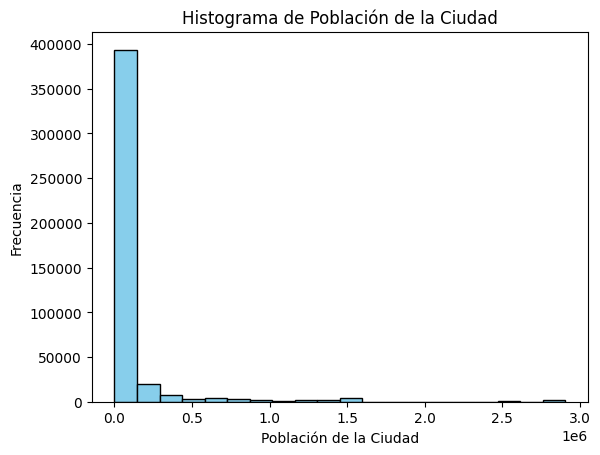

In [203]:
# Visualizar el histograma de la población de la ciudad
# Display the histogram of the city's population
plt.hist(X_train['city_pop'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Población de la Ciudad')
plt.ylabel('Frecuencia')
plt.title('Histograma de Población de la Ciudad')
plt.show()


C:\Users\julio\AppData\Local\Temp\ipykernel_4040\1221832137.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train['city_pop'], shade=True, color='skyblue')


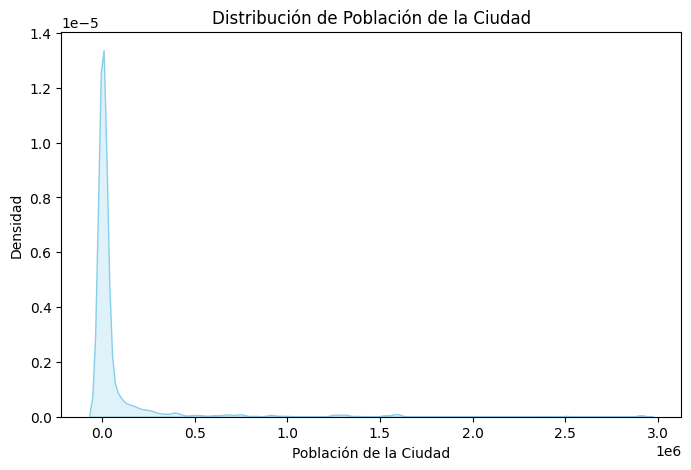

In [204]:
# Visualizar la distribución de la población de la ciudad
# Visualize the distribution of the city's population
plt.figure(figsize=(8, 5))
sns.kdeplot(X_train['city_pop'], shade=True, color='skyblue')
plt.xlabel('Población de la Ciudad')
plt.ylabel('Densidad')
plt.title('Distribución de Población de la Ciudad')
plt.show()


In [205]:
scaler = MinMaxScaler()
X_train['city_pop_normalized'] = scaler.fit_transform(X_train[['city_pop']])
X_train['norm_amount'] = scaler.fit_transform(X_train[['amt']])

In [206]:
X_train = pd.get_dummies(X_train, columns=['category'], prefix='category')

In [207]:
# Convertir la columna 'gender' a una variable binaria (0 para M, 1 para F)
# Convert the 'gender' column to a binary variable (0 for M, 1 for F)
X_train['gender_binary'] = X_train['gender'].map({'M': 0, 'F': 1})

# Eliminar la columna original 'gender'
# Remove the original 'gender' column 
X_train.drop(columns=['gender'], inplace=True)

In [208]:
# Utilizamos pandas get_dummies para aplicar one-hot encoding a la columna 'state'
# Use pandas get_dummies to apply one-hot encoding to the 'state' column
X_train = pd.get_dummies(X_train, columns=['state'], prefix='state')

In [209]:
# Convertir la columna 'date_trans' a tipo datetime si no lo está
# Convert column 'date_trans' to datetime type if it is not
X_train['date_trans'] = pd.to_datetime(X_train['date_trans'])

# Extraer el día de la semana (lunes=0, domingo=6) y convertirlo a nombre del día
# Extract the day of the week (Monday=0, Sunday=6) and convert it to day name
X_train['day_of_week'] = X_train['date_trans'].dt.dayofweek
X_train['day_of_week'] = X_train['day_of_week'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

# Utilizar get_dummies para aplicar one-hot encoding a la columna 'day_of_week'
# Use get_dummies to apply one-hot encoding to the 'day_of_week' column
X_train = pd.get_dummies(X_train, columns=['day_of_week'], prefix='day')

# Eliminar la columna original 'date_trans' si ya no la necesitas
# Remove the original 'date_trans' column if you no longer need it
X_train.drop(columns=['date_trans'], inplace=True)

In [210]:
# Crear un objeto KMeans con el número de clusters deseado
# Create a KMeans object with the desired number of clusters
num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters)

# Ajustar el modelo KMeans a la columna 'distance_kms'
# Fit the KMeans model to the 'distance_kms' column
kmeans.fit(X_train[['distance_kms']])

# Asignar las etiquetas de cluster a cada fila en el DataFrame
# Assign cluster labels to each row in the DataFrame
X_train['distance_cluster'] = kmeans.labels_

c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [211]:
# Calcular los valores máximos y mínimos de 'distance_kms' por cluster
# Calculate the maximum and minimum values of 'distance_kms' per cluster
cluster_stats = X_train.groupby('distance_cluster')['distance_kms'].agg(['min', 'max', 'count'])

# Mostrar los resultados
# Show results
print(cluster_stats)


                  min  max   count
distance_cluster                  
0                  91  150  150152
1                   0   55  113771
2                  56   90  180652


In [212]:
# Utilizar get_dummies para aplicar one-hot encoding a la columna 'category_job'
# Use get_dummies to apply one-hot encoding to the 'category_job' column
X_train = pd.get_dummies(X_train, columns=['category_job'], prefix='job')


In [213]:
X_train.head()


,amt,city,city_pop,job,hour_trans,age,distance_kms,e_commerce,basic_needs,rec_expenses,...,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,distance_cluster,job_arte_medios_entretenimiento,job_educacion_servicios_sociales,job_industria_tecnologia,job_negocios_finanzas,job_salud_ciencias_vida
139526,61.74,Washington,601723,"optician, dispensing",11,54,100,False,True,True,...,True,False,False,False,0,False,False,False,False,True
395747,186.93,Brunson,1725,social researcher,15,50,66,False,False,False,...,False,False,False,False,2,False,True,False,False,False
395119,127.61,Parks,759,"geologist, engineering",11,67,112,False,True,True,...,False,False,False,False,0,False,False,True,False,False
552207,16.46,Dongola,2263,scientific laboratory technician,23,40,98,False,False,True,...,False,False,False,True,0,False,False,True,False,False
487836,47.61,Kansas City,545147,counsellor,16,37,49,False,False,True,...,False,False,False,True,1,False,False,False,True,False


In [214]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444575 entries, 139526 to 121958
Data columns (total 90 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   amt                               444575 non-null  float64
 1   city                              444575 non-null  object 
 2   city_pop                          444575 non-null  int64  
 3   job                               444575 non-null  object 
 4   hour_trans                        444575 non-null  int32  
 5   age                               444575 non-null  int32  
 6   distance_kms                      444575 non-null  int32  
 7   e_commerce                        444575 non-null  bool   
 8   basic_needs                       444575 non-null  bool   
 9   rec_expenses                      444575 non-null  bool   
 10  city_pop_normalized               444575 non-null  float64
 11  norm_amount                       444575 non-null  f

In [215]:
# Lista de columnas a eliminar
# List of columns to remove
columnas_a_eliminar = ['city', 'job',]

# Eliminar las columnas del DataFrame
# Delete the columns from the DataFrame
X_train = X_train.drop(columnas_a_eliminar, axis=1)

# Verificar el DataFrame actualizado
# Check the updated DataFrame
print(X_train.head())


           amt  city_pop  hour_trans  age  distance_kms  e_commerce  \
139526   61.74    601723          11   54           100       False   
395747  186.93      1725          15   50            66       False   
395119  127.61       759          11   67           112       False   
552207   16.46      2263          23   40            98       False   
487836   47.61    545147          16   37            49       False   

        basic_needs  rec_expenses  city_pop_normalized  norm_amount  ...  \
139526         True          True             0.207006     0.002668  ...   
395747        False         False             0.000586     0.008167  ...   
395119         True          True             0.000253     0.005561  ...   
552207        False          True             0.000771     0.000679  ...   
487836        False          True             0.187542     0.002047  ...   

        day_Sunday  day_Thursday  day_Tuesday  day_Wednesday  \
139526        True         False        False       

## Pipeline rudimentario

Copio todas las transformaciones que he realizado en el train, y las aplico en el test

In [216]:
X_test['trans_date_trans_time'] = pd.to_datetime(X_test['trans_date_trans_time'], format='%d/%m/%Y %H:%M')
X_test['date_trans'] = X_test['trans_date_trans_time'].dt.date
X_test['hora'] = X_test['trans_date_trans_time'].dt.time
X_test['hora'] = pd.to_datetime(X_test['hora'], format='%H:%M:%S')
X_test['hour_trans'] = X_test['hora'].dt.hour

X_test['dob'] = pd.to_datetime(X_test['dob'], format='%d/%m/%Y')
X_test['yob'] = X_test['dob'].dt.year

current_year = datetime.now().year

X_test['age'] = current_year - X_test['yob']

X_test['distance_kms'] = haversine_distance(X_test['lat'], X_test['long'], X_test['merch_lat'], X_test['merch_long'])

X_test['distance_kms'] = X_test['distance_kms'].astype(int)

X_test = X_test.drop(columns=columns_to_drop)

X_test['job'] = X_test['job'].str.lower()
X_test['category_job'] = X_test['job'].apply(categorizar_trabajo)

X_test['e_commerce'] = X_test['category'].apply(lambda x: True if x.endswith('net') else False)

X_test['basic_needs'] = False

X_test.loc[X_test['category'].isin(['grocery_pos', 'grocery_net', 'gas_transport']), 'basic_needs'] = True

X_test['rec_expenses'] = False

X_test.loc[X_test['category'].isin(['grocery_pos', 'grocery_net', 'gas_transport', 'kids_pets', 'personal_care', 'health_fitness', 'food_dining']), 'rec_expenses'] = True

X_test['city_pop_normalized'] = scaler.fit_transform(X_test[['city_pop']])
X_test['norm_amount'] = scaler.fit_transform(X_test[['amt']])

X_test = pd.get_dummies(X_test, columns=['category'], prefix='category')

X_test['gender_binary'] = X_test['gender'].map({'M': 0, 'F': 1})

X_test.drop(columns=['gender'], inplace=True)

X_test = pd.get_dummies(X_test, columns=['state'], prefix='state')

X_test['date_trans'] = pd.to_datetime(X_test['date_trans'])

X_test['day_of_week'] = X_test['date_trans'].dt.dayofweek
X_test['day_of_week'] = X_test['day_of_week'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

X_test = pd.get_dummies(X_test, columns=['day_of_week'], prefix='day')

X_test.drop(columns=['date_trans'], inplace=True)

num_clusters = 3 
kmeans = KMeans(n_clusters=num_clusters)

kmeans.fit(X_test[['distance_kms']])

X_test['distance_cluster'] = kmeans.labels_

X_test = pd.get_dummies(X_test, columns=['category_job'], prefix='job')

X_test = X_test.drop(columnas_a_eliminar, axis=1)

c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [217]:
# Crear un clasificador XGBoost
# Create an XGBoost classifier
model = xgb.XGBClassifier()

In [218]:
# Entrenar el modelo
# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [219]:
# Hacer predicciones en el conjunto de prueba
# Make predictions on the test set
y_pred = model.predict(X_test)

In [220]:
# Evaluar el rendimiento del modelo
# Evaluate model performance
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110718
           1       0.95      0.81      0.87       426

    accuracy                           1.00    111144
   macro avg       0.97      0.90      0.94    111144
weighted avg       1.00      1.00      1.00    111144



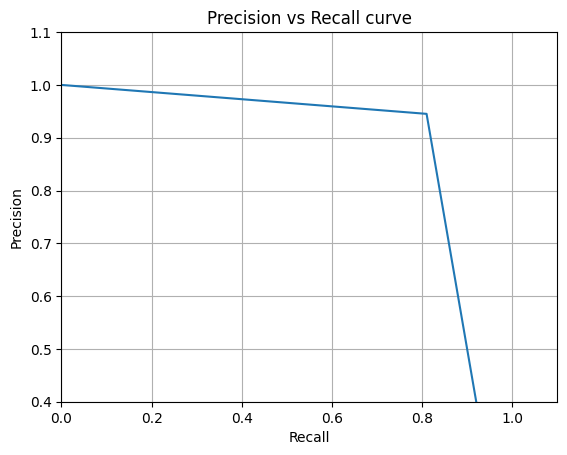

In [222]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlim([0.0, 1.1])
plt.ylim([0.4, 1.1])
plt.title('Precision vs Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True);

[[110698     20]
 [    81    345]]


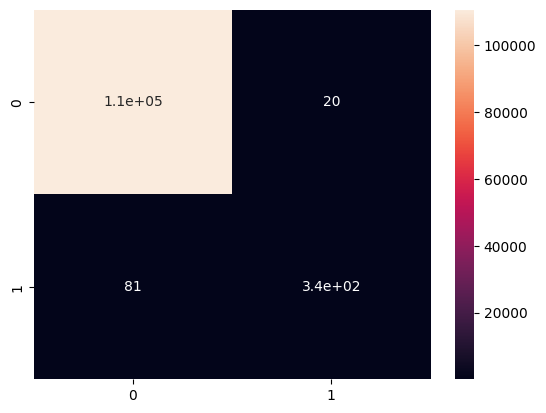

In [223]:
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)

sns.heatmap(c_matrix, annot=True);

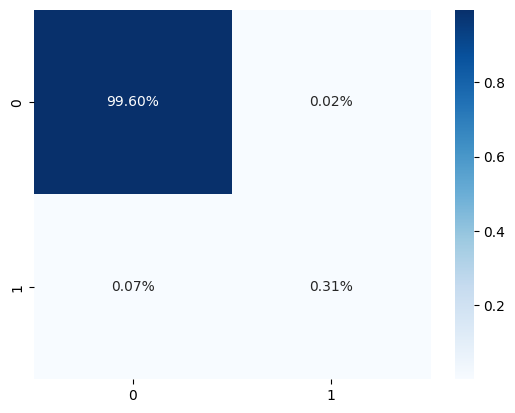

In [224]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues');

In [242]:
model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [225]:
grid_1 = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [227]:
fit_params = {'early_stopping_rounds':10,
              'eval_metric' : 'logloss',
              'eval_set' : [(X_test,y_test)]}

In [232]:
clf = GridSearchCV(model, grid_1, cv = 3, scoring='accuracy')

In [233]:
clf.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy')

In [234]:
clf.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [235]:
clf.best_score_

0.9988640837108256

In [236]:
best_xgb = clf.best_estimator_

In [237]:
y_preds = best_xgb.predict(X_test)

In [240]:
acc = accuracy_score(y_test,y_preds)

In [241]:
acc

0.9991182609947455

In [243]:
metricas_optimizadas = {}

In [247]:
### XGBoost

xgb_clf = XGBClassifier()

param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }



In [250]:
xgb_grid = RandomizedSearchCV(xgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "accuracy")




In [ ]:
xgb_grid.fit(X_train, y_train)
print("XGB best_score:", xgb_grid.best_score_)
metricas_optimizadas["XGBoost"] = xgb_grid.best_score_

In [248]:
xgb_grid.fit(X_test, y_test)
print("XGB best_score:", xgb_grid.best_score_)
metricas_optimizadas["XGBoost"] = xgb_grid.best_score_

XGB best_score: 0.9984704527459871


In [249]:
best_params = xgb_grid.best_params_
print("Mejores parámetros encontrados por RandomizedSearchCV:")
print(best_params)

Mejores parámetros encontrados por RandomizedSearchCV:
{'subsample': 0.8999999999999999, 'n_estimators': 750, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7}


In [251]:
# Definir los mejores parámetros encontrados por RandomizedSearchCV
# Define the best parameters found by RandomizedSearchCV
best_params = {'max_depth': [3], 
               'learning_rate': [0.2], 
               'subsample': [0.9], 
               'colsample_bytree': [0.7], 
               'colsample_bylevel': [0.7], 
               'n_estimators': [750]}

# Inicializar el modelo XGBoost
# Initialize the XGBoost model
xgb_clf = XGBClassifier()

# Inicializar RandomizedSearchCV con los mejores parámetros encontrados
# Initialize RandomizedSearchCV with the best parameters found
xgb_grid = RandomizedSearchCV(xgb_clf, 
                              param_distributions=best_params, 
                              cv=3, 
                              scoring='accuracy', 
                              n_iter=1,  
                              random_state=42)

# Entrenar el modelo con los nuevos parámetros
# Train the model with the new parameters
xgb_grid.fit(X_train, y_train)

# Obtener el mejor modelo
# Get the best model
best_xgb_model = xgb_grid.best_estimator_

# Imprimir el mejor score y los mejores parámetros
# Print the best score and the best parameters
print("Mejor score:", xgb_grid.best_score_)
print("Mejores parámetros:", xgb_grid.best_params_)


Mejor score: 0.9987853567862487
Mejores parámetros: {'subsample': 0.9, 'n_estimators': 750, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7}


In [252]:
# Hacer predicciones en el conjunto de datos de prueba
# Make predictions on the test data set
y_pred = best_xgb_model.predict(X_test)

In [253]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo en el conjunto de prueba:", accuracy)

Precisión del modelo en el conjunto de prueba: 0.9989653062693443


In [255]:
# Calcula las métricas de evaluación
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprime las métricas de evaluación
# Print the evaluation metrics
print("Precisión:", accuracy)
print("Exhaustividad:", recall)
print("Precisión:", precision)
print("Puntaje F1:", f1)
print("AUC-ROC:", roc_auc)
print("Matriz de confusión:\n", conf_matrix)

Precisión: 0.9989653062693443
Exhaustividad: 0.7863849765258216
Precisión: 0.9331476323119777
Puntaje F1: 0.8535031847133758
AUC-ROC: 0.8930841048022268
Matriz de confusión:
 [[110694     24]
 [    91    335]]


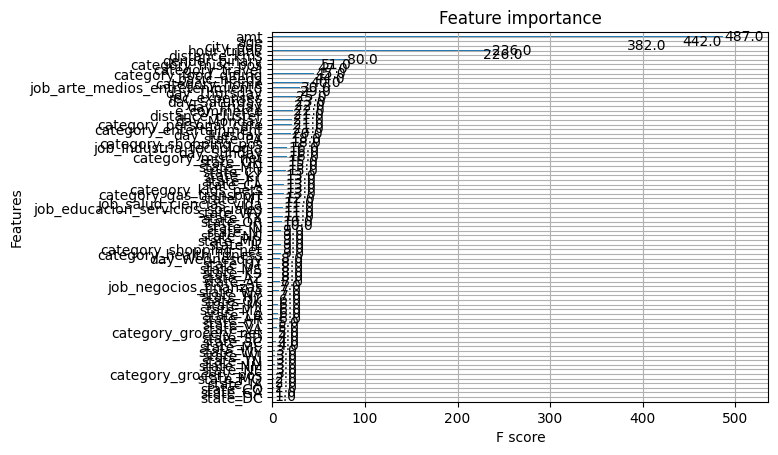

In [379]:
xgb.plot_importance(model)
plt.show()

In [380]:
# Obtener la importancia de las características del modelo
# Get the importance of model features
importance = model.get_booster().get_score(importance_type='weight')

# Crear un DataFrame con las características y sus importancias
# Create a DataFrame with the characteristics and their importance
df_importance = pd.DataFrame(list(importance.items()), columns=['Característica', 'Importancia'])
df_importance.sort_values(by='Importancia', ascending=False, inplace=True)


In [381]:
# Configurar pandas para mostrar todas las filas y columnas
# Configure pandas to show all rows and columns
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
df_importance

,Característica,Importancia
0,amt,487.0
3,age,442.0
1,city_pop,382.0
2,hour_trans,236.0
4,distance_kms,226.0
22,gender_binary,80.0
17,category_misc_pos,51.0
21,category_travel,47.0
9,category_food_dining,45.0
6,basic_needs,44.0


In [384]:
# Guardar el modelo en un archivo .pkl
# Save the model to a .pkl file
joblib.dump(model, 'modelo_xgboost_fraud.pkl')

['modelo_xgboost_fraud.pkl']